In [1]:
import os
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
def read_and_process_mhd_files(directory, clip_range=(-1000, 1000), new_slice_size=(128, 128), new_depth_size=64):
    mhd_files = [file for file in os.listdir(directory) if file.endswith('.mhd')]
    ct_scans = []
    for file in mhd_files:
        file_path = os.path.join(directory, file)
        ct_scan = process_mhd_file(file_path, clip_range, new_slice_size, new_depth_size)
        ct_scans.append(ct_scan)
    return ct_scans

def process_mhd_file(file_path, clip_range, new_slice_size, new_depth_size):
    mhd_file = sitk.ReadImage(file_path)
    ct_scan = sitk.GetArrayFromImage(mhd_file)
    ct_scan = ct_scan.astype(np.float32)
    np.clip(ct_scan, clip_range[0], clip_range[1], out=ct_scan)
    ct_scan = (ct_scan - clip_range[0]) / (clip_range[1] - clip_range[0])
    resized_ct_scan = resize_slices(ct_scan, new_slice_size, new_depth_size)
    return resized_ct_scan

def resize_slices(ct_scan, new_slice_size, new_depth_size):
    depth_factor = new_depth_size / ct_scan.shape[0]
    height_factor = new_slice_size[0] / ct_scan.shape[1]
    width_factor = new_slice_size[1] / ct_scan.shape[2]
    resized_ct_scan = zoom(ct_scan, (depth_factor, height_factor, width_factor), order=1)
    return resized_ct_scan

# 데이터 로드 및 전처리
positive_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/subset1/positive"
negative_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/subset1/negative"

In [3]:
positive_scans = read_and_process_mhd_files(positive_directory)

In [4]:
negative_scans = read_and_process_mhd_files(negative_directory)

In [7]:
for i in positive_scans:
    print(i.shape)

(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)


In [27]:
# 라벨링 및 데이터 결합
positive_labels = [1] * len(positive_scans)
negative_labels = [0] * len(negative_scans)

X = np.array(positive_scans + negative_scans)
y = np.array(positive_labels + negative_labels)

# 데이터셋 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)

In [28]:

# 모델 정의
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64, 128, 128, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 데이터 차원 조정 (채널 추가)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)



C:\Users\Taeho\anaconda3\envs\lung_cancer\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_val, y_val))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6033 - loss: 9.8290 - val_accuracy: 0.6667 - val_loss: 0.6890
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6308 - loss: 0.6897 - val_accuracy: 0.6667 - val_loss: 0.6852
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6537 - loss: 0.6867 - val_accuracy: 0.6667 - val_loss: 0.6467
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8080 - loss: 0.5879 - val_accuracy: 0.6667 - val_loss: 0.6575
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7349 - loss: 0.5469 - val_accuracy: 0.6667 - val_loss: 0.6552
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6345 - loss: 0.6494 - val_accuracy: 0.6111 - val_loss: 0.6616
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7616 - loss: 0.5578 - val_accuracy: 0.6111 - val_loss: 0.6844
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8251 - loss: 0.4039 - val_accuracy: 0.5556 - val_loss:

In [35]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

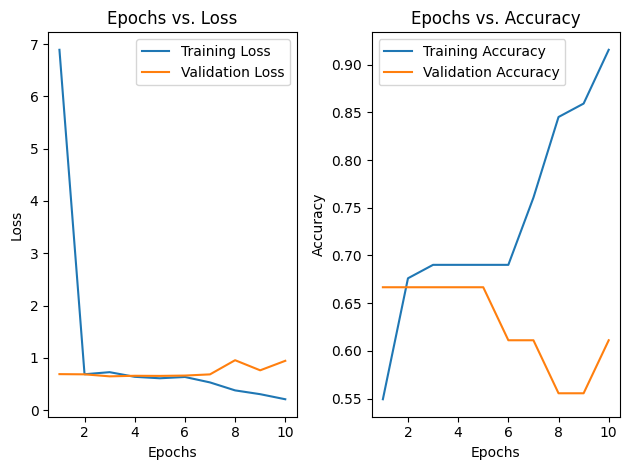

In [33]:
# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs. Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6111 - loss: 0.9437
Test Loss: 0.9436509013175964
Test Accuracy: 0.6111111044883728


In [ ]:
#####

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 모델 정의 (Dropout 레이어 추가)
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64, 128, 128, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping과 ReduceLROnPlateau 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [38]:
# 모델 훈련 (콜백 추가)
history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6478 - loss: 1.6910 - val_accuracy: 0.6667 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5908 - loss: 0.6912 - val_accuracy: 0.6667 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6540 - loss: 0.6853 - val_accuracy: 0.6667 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6749 - loss: 0.6788 - val_accuracy: 0.6667 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6437 - loss: 0.7327 - val_accuracy: 0.6667 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5130 - loss: 0.6907 - val_accuracy: 0.6667 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5741 - loss: 0.6797 - val_accuracy: 

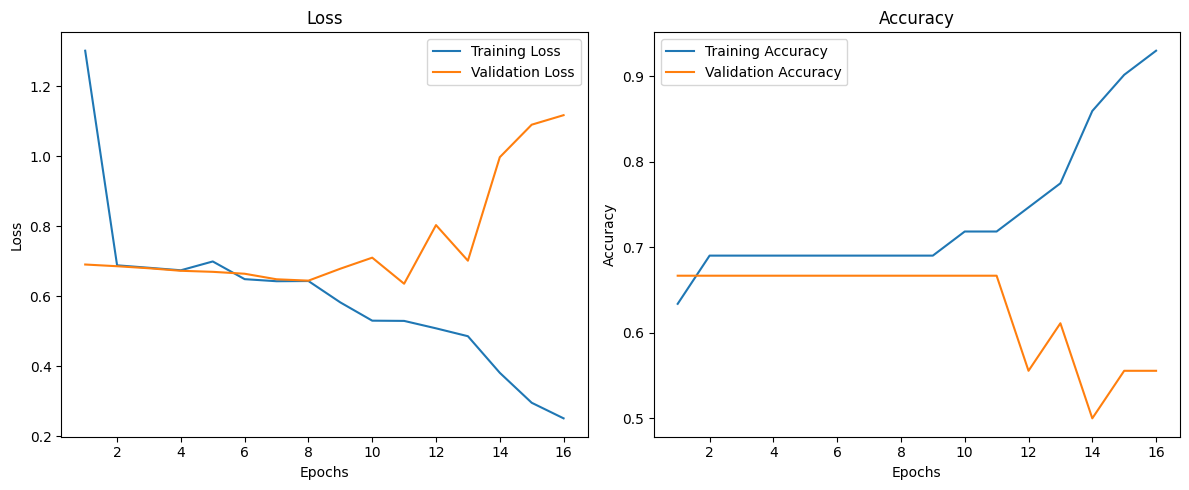

In [43]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 0.6359
Test Loss: 0.635886549949646
Test Accuracy: 0.6666666865348816
